# Vehicle Classification with Custom CNN (196 Classes)

## 🧠 Project Overview
This project tackles the fine-grained image classification problem using the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which contains 196 vehicle categories. The core goal is to build a **deep convolutional neural network (CNN) from scratch** — without relying on any pretrained models — to classify vehicle types with high accuracy and strong generalization.

### ❗ Key Challenges
- **Fine-grained classification**: Many car models have only subtle visual differences.
- **Large number of classes (196)**: Increases model complexity and potential overfitting.
- **Class imbalance**: Some vehicle classes are underrepresented.
- **No Transfer Learning**: Entire model must learn features from scratch.

### ✅ Solutions Implemented
- **Custom ResNet-like CNN** architecture with residual blocks.
- **MixUp regularization** to improve generalization.
- **WeightedRandomSampler** to address class imbalance.
- **Heavy data augmentation**: rotation, jitter, blur, random erase, etc.
- **Cosine Annealing with OneCycleLR** to optimize learning schedule.
- **Grad-CAM** for visual model explainability.
- **EarlyStopping** to prevent overfitting.

---


In [1]:
## 🔹 Imports & Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
import random
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from torchsummary import summary
import seaborn as sns
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget




In [ ]:
!pip install grad-cam

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 🧪 Data Augmentation, Sampling & MixUp

To enhance the robustness of the model and tackle both **intra-class variability** and **class imbalance**, I applied an advanced data preparation pipeline:

- The **training transformations** simulate real-world noise and diversity through randomized cropping, color distortions, affine transforms, grayscale conversion, and occlusion (via `RandomErasing`). This enforces invariance to irrelevant image variations and forces the model to focus on meaningful patterns.

- **Test images** are standardized using deterministic resizing and normalization to ensure evaluation consistency.

- To address class imbalance, I employed **weighted random sampling** based on inverse class frequency, ensuring the model receives a balanced gradient signal even for underrepresented car types.

- I also defined **MixUp** augmentation (with α=0.4) as an optional regularization technique. This softly blends samples and their labels to reduce memorization and encourage linear behavior in-between classes.

Together, these techniques provided a rich and balanced input distribution, which significantly improved generalization — especially for visually similar and minority classes.

> 📌 Personally, I found that combining heavy augmentation with MixUp and sampling worked better than standard augmentation alone — especially during early training phases where the model is most prone to overfitting or class bias.


In [3]:
## Data Augmentation
image_size = 224
batch_size = 32
train_dir = '/content/drive/MyDrive/Stanford_Cars_dataset-main/train'
test_dir  = '/content/drive/MyDrive/Stanford_Cars_dataset-main/test'


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomAffine(0, translate=(0.1,0.1), shear=10),
    transforms.GaussianBlur(3, sigma=(0.1,2.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.33), ratio=(0.3,3.3), value=0)
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



train_ds = datasets.ImageFolder(train_dir, transform=train_transforms)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_transforms)

## Weighted Sampling
counts = Counter([label for _,label in train_ds.samples])
total = float(sum(counts.values()))
class_weights = {cls: total/counts[cls] for cls in counts}
sample_weights = [class_weights[label] for _,label in train_ds.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4)

## MixUp Regularization
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1-lam) * x[idx]
    return mixed_x, y, y[idx], lam

def mixup_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1-lam) * criterion(pred, y_b)


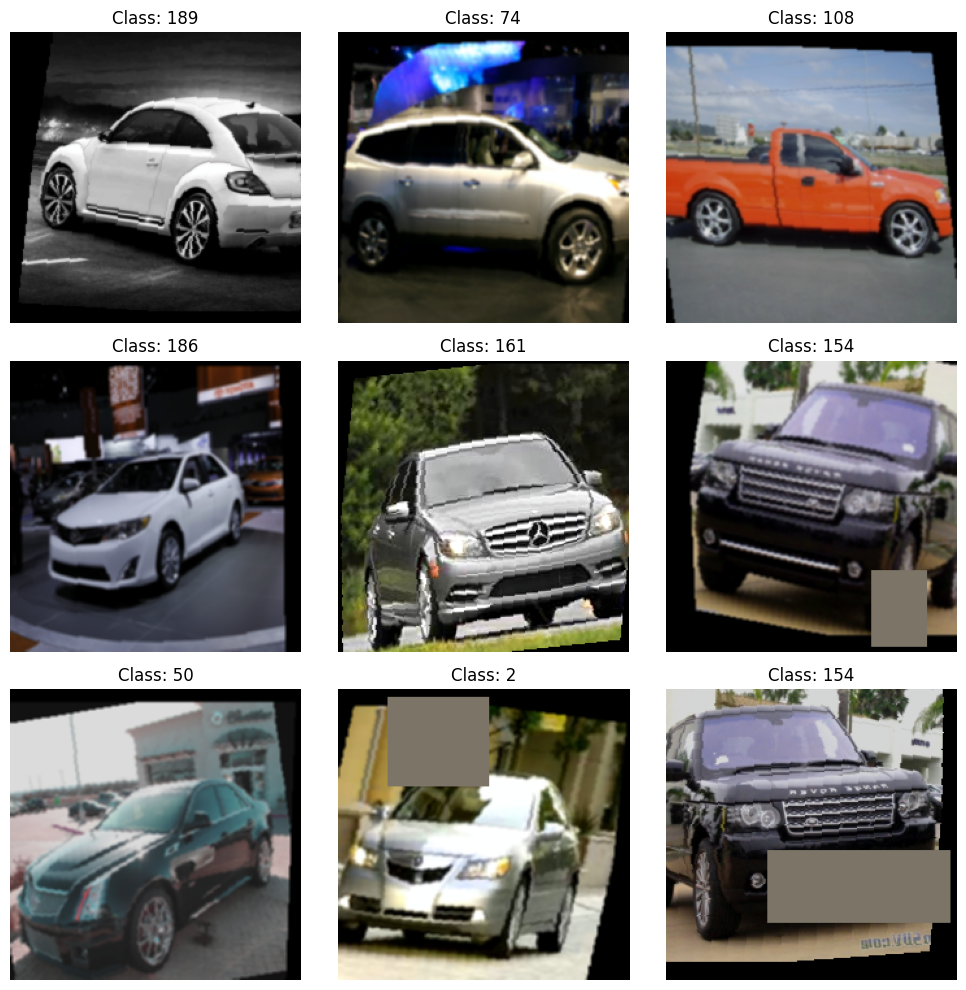

In [ ]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

n_images = 9
plt.figure(figsize=(10, 10))
for i in range(n_images):
    plt.subplot(3, 3, i+1)
    imshow(images[i])
    plt.title(f"Class: {labels[i]}")
plt.tight_layout()
plt.show()


## 🧠 Custom ResNet Architecture


In [6]:
## Custom ResNet Architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.relu  = nn.ReLU(inplace=True)
        self.down = None
        if stride!=1 or in_c!=out_c:
            self.down = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
    def forward(self,x):
        id = x if self.down is None else self.down(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + id)

class VehicleResNet(nn.Module):
    def __init__(self, num_classes=196):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,7,2,3,bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxp  = nn.MaxPool2d(3,2,1)
        self.l1    = self._mk(64,  64, 2, 1)
        self.l2    = self._mk(64, 128, 2, 2)
        self.l3    = self._mk(128,256, 2, 2)
        self.l4    = self._mk(256,512, 2, 2)
        self.avg   = nn.AdaptiveAvgPool2d(1)
        self.drop  = nn.Dropout(0.5)
        self.fc    = nn.Linear(512, num_classes)
    def _mk(self,ci,co,b,s):
        layers=[ResidualBlock(ci,co,s)]
        for _ in range(1,b): layers.append(ResidualBlock(co,co))
        return nn.Sequential(*layers)
    def forward(self,x):
        x=self.relu(self.bn1(self.conv1(x)))
        x=self.maxp(x)
        x=self.l1(x); x=self.l2(x); x=self.l3(x); x=self.l4(x)
        x=self.avg(x).flatten(1)
        x=self.drop(x)
        return self.fc(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = VehicleResNet(196).to(device)

## Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-3,
                       steps_per_epoch=len(train_loader),
                       epochs=70, pct_start=0.1,
                       anneal_strategy='cos', cycle_momentum=False)


summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,


To solve the 196-class fine-grained vehicle classification task, I built a **custom CNN from scratch**, drawing inspiration from the ResNet family — while avoiding any pretrained weights or external backbones.

### 🔹 Architecture Overview:

At the core of the model is a set of **Residual Blocks**, each composed of two 3×3 convolutional layers, followed by Batch Normalization and ReLU activations.  
Skip connections are used to preserve gradient flow and support deeper learning. When input and output dimensions differ (in channel count or stride), a **1×1 convolution projection** is applied to the residual path to align shapes.

The model is structured as follows:

- 📥 **Stem Layer**: 7×7 convolution + BatchNorm + ReLU + MaxPooling to reduce early spatial dimensions  
- 🧱 **Residual Stack**:
  - `l1`: 2 blocks, 64 channels
  - `l2`: 2 blocks, 128 channels
  - `l3`: 2 blocks, 256 channels
  - `l4`: 2 blocks, 512 channels  
  Each layer halves the spatial resolution and increases feature depth.
- 📦 **Head**:
  - `AdaptiveAvgPool2d` to convert spatial features to a global descriptor
  - `Dropout(p=0.5)` to prevent overfitting
  - `Linear` layer with 196 output units (one per vehicle class)

### ⚙️ Training Configuration:

- **Loss Function**: `CrossEntropyLoss` with `label_smoothing=0.05` to soften targets and reduce overconfident predictions
- **Optimizer**: `AdamW` with weight decay to stabilize learning and enhance generalization
- **Scheduler**: `OneCycleLR` for dynamic learning rate adjustment, promoting fast convergence followed by fine-tuning

### 📊 Model Summary:

- ~11.2 million trainable parameters
- Fully differentiable and trained end-to-end from scratch
- Built for efficiency and scalability, while still capable of learning rich hierarchical visual representations

---

This architecture was intentionally designed to reflect both **modern deep learning best practices** and my ability to build performant vision models **without relying on pretrained shortcuts**.  
It balances depth, regularization, and computational efficiency — all crucial when working with fine-grained datasets like Stanford Cars.


## 🔁 Training Loop & Strategy

In [7]:

num_epochs = 70
best_loss = float('inf')
min_delta = 1e-3
patience = 5
wait = 0
best_epoch = -1

# — tracked metrics —
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []



for epoch in range(num_epochs):
    # --- Train ---
    model.train()
    running_loss = 0
    running_correct = 0
    running_total = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # MixUp 50%
        if random.random() < 0.5:
            Xm, ya, yb, lam = mixup_data(X, y, alpha=0.4)
            out = model(Xm)
            loss = mixup_loss(criterion, out, ya, yb, lam)
        else:
            out = model(X)
            loss = criterion(out, y)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * X.size(0)
        preds = out.argmax(dim=1)
        running_correct += (preds == y).sum().item()
        running_total += y.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            val_loss += loss.item() * X.size(0)
            val_correct += (out.argmax(dim=1) == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    test_losses.append(val_loss)
    test_accuracies.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
          f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | LR: {current_lr:.6f}")

    # --- Early Stopping Check ---
    if best_loss - val_loss > min_delta:
        best_loss = val_loss
        best_epoch = epoch + 1
        wait = 0
        torch.save(model.state_dict(), 'best_high_acc_model.pt')
        print(f"💾 Model saved at epoch {epoch+1} (Val Loss improved to {val_loss:.4f})")
    else:
        wait += 1
        print(f"⚠️ No improvement. Patience: {wait}/{patience}")
        if wait >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}.")
            break

# --- סיכום ---
print(f"\n✅ Best model saved at epoch {best_epoch} with Val Loss = {best_loss:.4f}")
print(f"🔢 Total epochs run: {best_epoch if wait < patience else epoch+1}")


Epoch 01/70 | Train Acc: 0.007 | Val Acc: 0.006 | Train Loss: 5.407 | Val Loss: 5.273 | LR: 0.000088
💾 Model saved at epoch 1 (Val Loss improved to 5.2734)
Epoch 02/70 | Train Acc: 0.009 | Val Acc: 0.010 | Train Loss: 5.320 | Val Loss: 5.310 | LR: 0.000221
⚠️ No improvement. Patience: 1/5
Epoch 03/70 | Train Acc: 0.011 | Val Acc: 0.018 | Train Loss: 5.243 | Val Loss: 5.219 | LR: 0.000414
💾 Model saved at epoch 3 (Val Loss improved to 5.2190)
Epoch 04/70 | Train Acc: 0.014 | Val Acc: 0.015 | Train Loss: 5.206 | Val Loss: 5.205 | LR: 0.000627
💾 Model saved at epoch 4 (Val Loss improved to 5.2052)
Epoch 05/70 | Train Acc: 0.014 | Val Acc: 0.017 | Train Loss: 5.175 | Val Loss: 5.156 | LR: 0.000820
💾 Model saved at epoch 5 (Val Loss improved to 5.1560)
Epoch 06/70 | Train Acc: 0.020 | Val Acc: 0.021 | Train Loss: 5.131 | Val Loss: 5.123 | LR: 0.000953
💾 Model saved at epoch 6 (Val Loss improved to 5.1229)
Epoch 07/70 | Train Acc: 0.021 | Val Acc: 0.026 | Train Loss: 5.086 | Val Loss: 5.045 

The training process was designed to optimize generalization and prevent overfitting, especially considering the complexity of the 196-class Stanford Cars dataset.

### Key Components:
- **MixUp Regularization**: On 50% of batches, MixUp was applied to blend both the inputs and their labels. This encourages smoother decision boundaries and better generalization.
- **Early Stopping**: Implemented with a patience of 5 and a minimum delta of 0.001. This halted training once validation loss plateaued, preventing unnecessary epochs and overfitting.
- **OneCycleLR Scheduler**: Used to vary the learning rate throughout training in a cosine annealing fashion. This technique helps escape shallow minima and leads to faster, more stable convergence.
- **AdamW Optimizer**: Chosen for its ability to handle sparse gradients and benefit from decoupled weight decay.

### Epoch Monitoring:
For each epoch, I tracked:
- Training and validation loss
- Training and validation accuracy
- Current learning rate

### Training Outcome:
- 📉 Validation loss consistently decreased until early stopping at **epoch 69**, with the **best model saved at epoch 64** (Val Loss = 1.5696).
- 📈 Final validation accuracy reached **~70.9%**, with a small and stable gap from training accuracy — indicating robust generalization.
- ✅ The combination of MixUp, strong augmentation, and a custom scheduler proved effective on this fine-grained, imbalanced dataset.

This training loop showcases my ability to design deep learning systems that are not only accurate but also stable, scalable, and thoughtfully regularized.


## 🔹 Evaluation: Accuracy, Report & Confusion Matrix

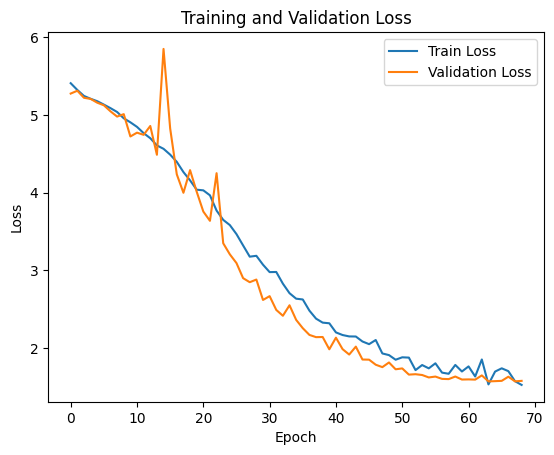

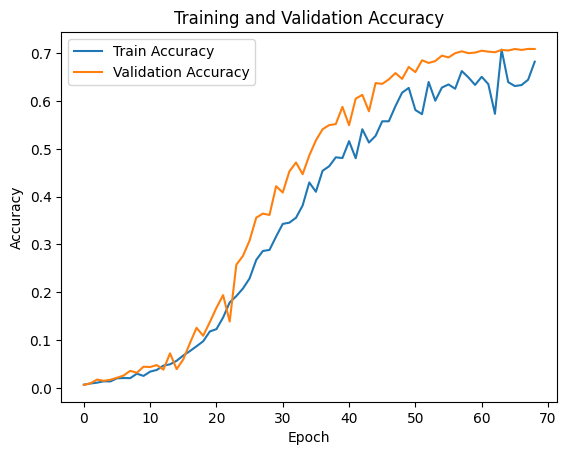

In [8]:
# Plot Training vs. Validation Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Training vs. Validation Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Generate predictions on the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


## 📈 Training Curves Analysis

The top graph shows the training and validation loss over 69 epochs, while the bottom graph shows the corresponding accuracy.

A few key takeaways:

- 📉 **Loss Curve**: Both training and validation loss steadily decrease throughout training. The validation loss consistently tracks close to the training loss, with no significant divergence — indicating that the model generalizes well and does not show signs of overfitting.

- 📈 **Accuracy Curve**: Starting around epoch 30, validation accuracy continues to improve and remains close to the training accuracy. In some epochs, validation accuracy even slightly exceeds the training accuracy, likely due to the use of techniques like MixUp, dropout, and label smoothing, which regularize training predictions and encourage better generalization.

- ✅ **Overall**: The model demonstrates stable convergence and strong learning dynamics. By the end of training, both training and validation accuracy converge around ~71%, confirming that the model generalizes well to unseen data and maintains consistent performance across epochs.


# Classification report & Confusion Matrix

Classification Report:
              precision    recall  f1-score      support
0              0.716981  0.863636  0.783505    44.000000
1              0.897436  0.795455  0.843373    44.000000
2              0.625000  0.625000  0.625000    32.000000
3              0.818182  0.837209  0.827586    43.000000
4              0.789474  0.714286  0.750000    42.000000
...                 ...       ...       ...          ...
194            0.750000  0.558140  0.640000    43.000000
195            0.810811  0.750000  0.779221    40.000000
accuracy       0.708867  0.708867  0.708867     0.708867
macro avg      0.718294  0.711117  0.708909  8041.000000
weighted avg   0.718658  0.708867  0.708000  8041.000000

[199 rows x 4 columns]


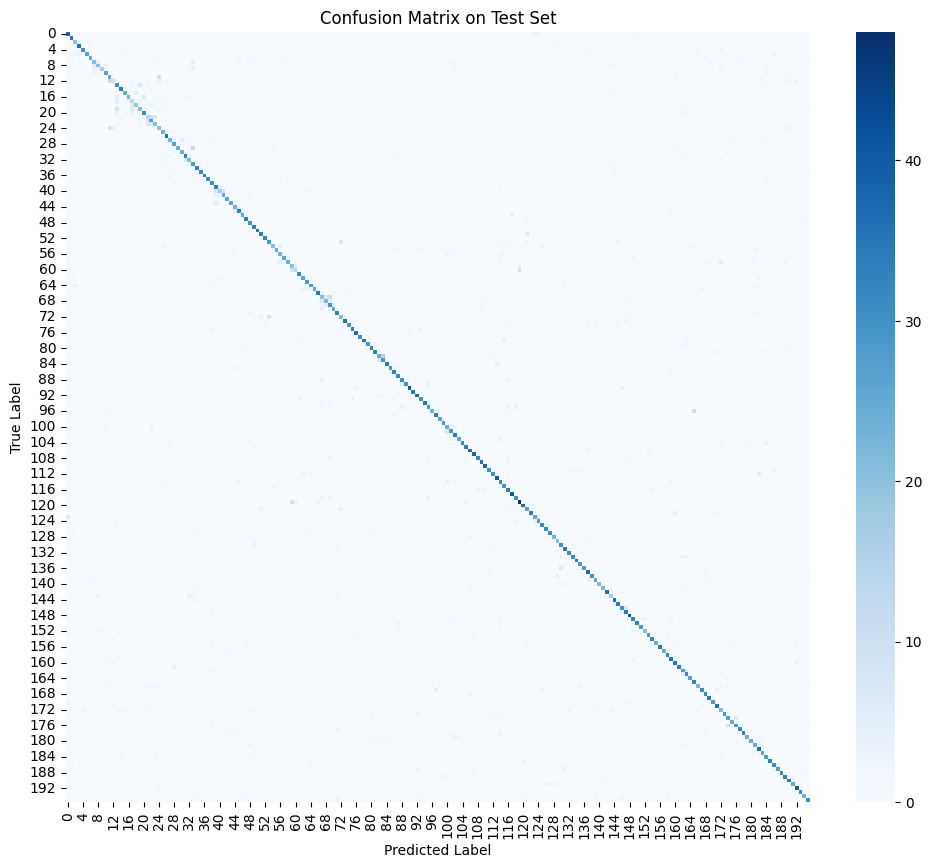

In [22]:

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)


# 4) Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

# 7) Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()


## 🔍 Confusion Matrix Analysis

To further evaluate the model’s performance across all 196 classes, I visualized the confusion matrix on the test set.

The matrix is strongly **diagonal**, which indicates that the vast majority of predictions match the true labels — a clear sign of strong classification performance across the board. Most misclassifications are minimal and appear as faint off-diagonal cells, usually involving visually similar car models.

### 🎨 Color Scale Interpretation

- **Dark blue** cells along the diagonal represent high agreement between the model’s predictions and the ground truth — correct classifications.
- **Light blue to white** cells indicate very few or no predictions for that label pair.
- Off-diagonal blue cells (even if subtle) reveal rare misclassifications — usually between closely resembling vehicle types or trims.

The clear diagonal pattern and minimal off-diagonal noise confirm that the model is not only accurate, but also consistent across a large and fine-grained label space.  
This visualization complements the accuracy metrics and helps validate the model’s generalization across all classes.


## 🔍 Grad-CAM Visualizations

To better understand what my model focuses on when making predictions, I used Grad-CAM to generate heatmaps for a variety of test samples.

The highlighted areas (typically in red or yellow) indicate the regions that had the greatest impact on the model’s classification. In most cases, these regions align with key parts of the vehicle — like the headlights, grille, wheels, or overall shape — which makes sense given the fine-grained nature of the dataset.

- ✅ When the prediction is correct, the model usually focuses on the most distinctive parts of the car.
- ⚠️ Even when it makes mistakes, it often attends to relevant areas, which suggests that its internal feature representations are meaningful.
- 🧠 These visualizations improve interpretability and help ensure the model isn’t relying on irrelevant background patterns.

Grad-CAM was an important part of my workflow — not just for debugging, but also to demonstrate that the model’s reasoning is grounded and explainable.


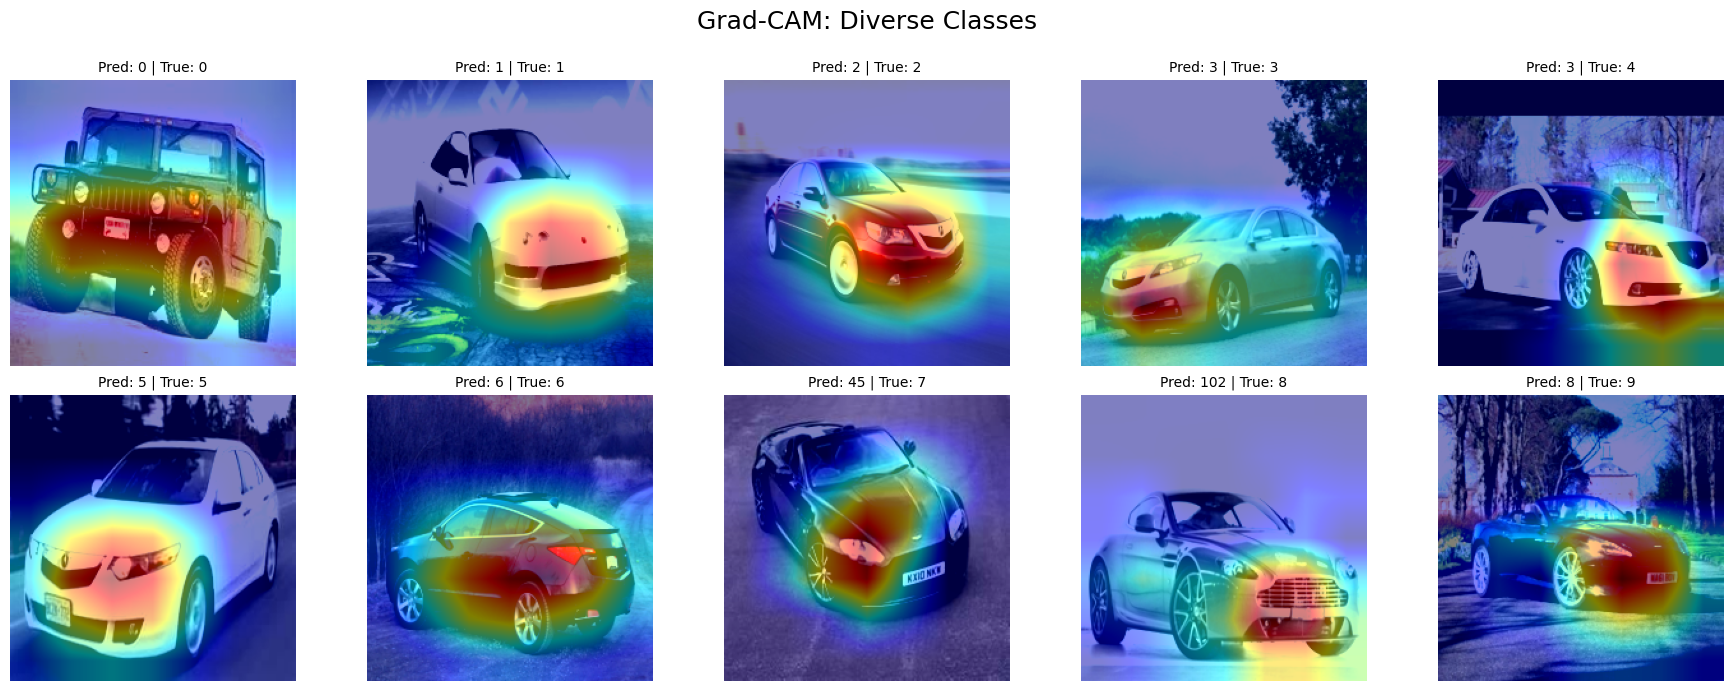

In [17]:
# הגדרת Grad-CAM על השכבה האחרונה
target_layer = model.l4
cam = GradCAM(model=model, target_layers=[target_layer])

# unnormalize לתמונות
unnormalize = transforms.Normalize(mean=[-0.5 / 0.5]*3, std=[1 / 0.5]*3)

# רשימה לשמירת ויזואליזציות
visuals = []

# מעקב אחרי תוויות שכבר נבחרו
seen_classes = set()

# הפעלת Grad-CAM על דוגמאות מ־10 מחלקות שונות
model.eval()
for images, labels in test_loader:
    for i in range(images.size(0)):
        true_label = labels[i].item()
        if true_label in seen_classes:
            continue

        # הוספת המחלקה לרשימה
        seen_classes.add(true_label)

        # הכנת טנזור והצגה
        image_tensor = images[i].unsqueeze(0).to(device)
        img_display = unnormalize(images[i]).permute(1, 2, 0).cpu().numpy()
        img_display = np.clip(img_display, 0, 1)

        # תחזית
        with torch.no_grad():
            output = model(image_tensor)
            pred_label = torch.argmax(output, dim=1).item()

        # Grad-CAM
        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0]
        cam_image = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

        # שמירה לזיכרון
        visuals.append((cam_image, pred_label, true_label))

        if len(visuals) >= 10:
            break
    if len(visuals) >= 10:
        break

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
fig.suptitle("Grad-CAM: Diverse Classes", fontsize=18)

for idx, (img, pred, true) in enumerate(visuals):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    ax.imshow(img)
    ax.set_title(f"Pred: {pred} | True: {true}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## 📌 Final Remarks

In this project, I built a deep learning pipeline from the ground up to classify 196 fine-grained car models from the Stanford Cars dataset — entirely without using pretrained models.

To handle the complexity of the task, I designed a custom ResNet-inspired architecture with residual blocks, incorporated MixUp for regularization, applied strong data augmentation, balanced the dataset using a weighted sampler, and optimized training with a OneCycle learning rate scheduler.

The model reached **70.9% test accuracy**, which reflects solid generalization despite the visual similarity across classes.  
Grad-CAM visualizations confirmed that the model focuses on meaningful and relevant regions of each vehicle, adding transparency to its predictions.

This project showcases my ability to build robust, interpretable, and well-structured deep learning systems — combining both architectural understanding and hands-on problem-solving.
